Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 encoder (Functional)        (None, 10, 10, 16)        694256    
                                                                 
 vector_quantizer (VectorQua  (None, 10, 10, 16)       1024      
 ntizer)                                                         
                                                                 
 decoder (Functional)        (None, 160, 160, 3)       755011    
                                                                 
Total params: 1,450,291
Trainable params: 1,450,291
Non-trainable params: 0
_________________________________________________________________
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Usi

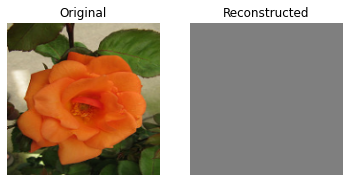

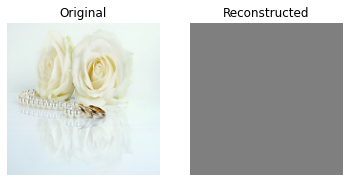

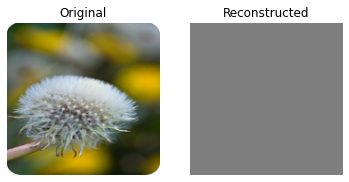

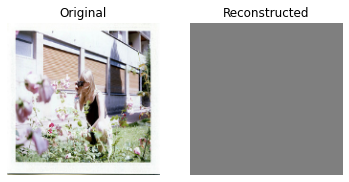

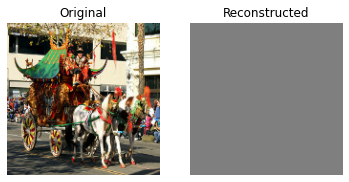

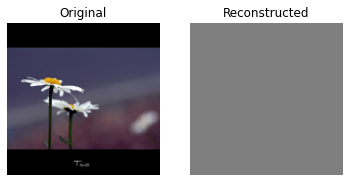

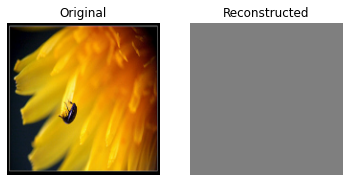

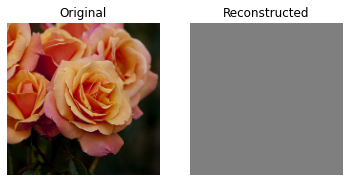

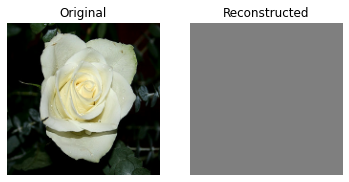

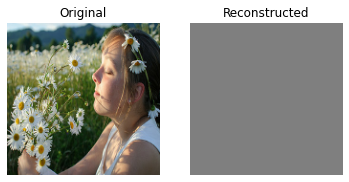

1/1 [==============================] - 1s 798ms/step


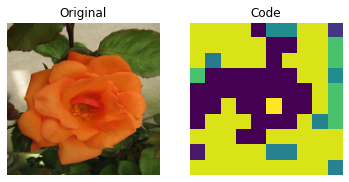

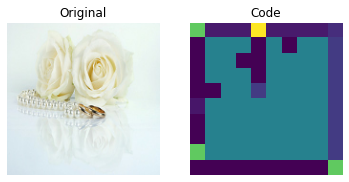

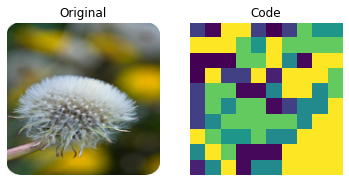

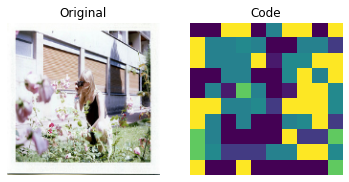

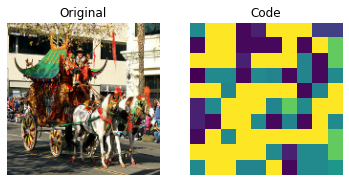

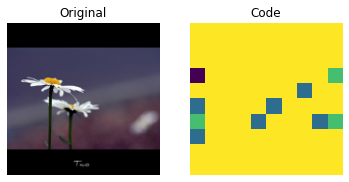

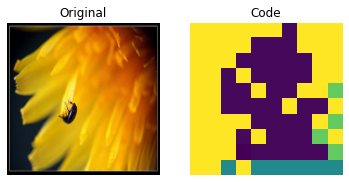

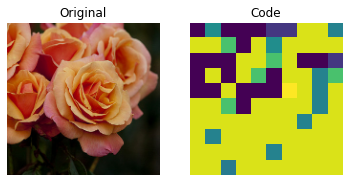

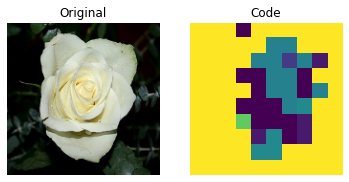

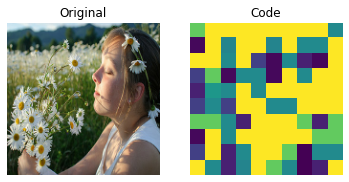

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers # keras for tensorflow.keras   
import tensorflow_probability as tfp
import tensorflow as tf
import pathlib
import pandas as pd
import os







class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices










def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(160, 160, 3))
    x = layers.Conv2D(32, 4, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 4, activation="relu", strides=2, padding="same")(x)#eventualmente aggiungere un residual block
    x = layers.Conv2D(128, 4, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(256, 4, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(256, 4, activation="relu", strides=2, padding="same")(
        latent_inputs
    ) #dimesion of the filter 4x4 because in the decoding you jump a row each two and with 3x3 you evaluate only the zeros around your central pixel
    x = layers.Conv2DTranspose(128, 4, activation="relu", strides=2, padding="same")(x) #dimesion of the filter
    x = layers.Conv2DTranspose(64, 4, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 4, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(3, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")















def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(160, 160, 3))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()













class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):#provare a fare un fit con un fit normale
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }











dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)


batch_size = 32
img_height = 160
img_width = 160


# training set
x_train = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
# trasformare il dataset in un array di numpy
x_train = np.concatenate([batch for batch,_ in x_train])


# testing set
x_test = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# trasformare il dataset in un array di numpy
x_test = np.concatenate([batch for batch,_ in x_test])


x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)


'''

# mnist dataset
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

'''












vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())


# creating the saves destinations for model and weights
filename = './checkpoints/model0.csv'
checkpoint_file = './checkpoints/model_flowers'
load_checkpoint = f'./checkpoints/model_flowers'
i = 1
while os.path.isfile(filename):
    filename = f'./checkpoints/model{i}.csv'
    load_checkpoint = f'./checkpoints/model_flowers{i-1}'
    checkpoint_file = f'./checkpoints/model_flowers{i}'
    i += 1

# training of the neural network and then saves as a .csv file the model parameters hystory
#params = vqvae_trainer.fit(x_train_scaled, epochs=30, batch_size=32)
#model_params = pd.DataFrame(params.history)
#model_params.to_csv(filename, index=False)# il file è pieno solo delle funzioni di loss ma non dei parametri del modella...???


# load the weights in checkpoint format
#vqvae_trainer.load_weights(load_checkpoint)


# saves the weights of the training
#vqvae_trainer.save_weights(checkpoint_file)








def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)












encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()
